# [Flexible Representation of Quantum Images - FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

> *Le, P.Q., Dong, F. and Hirota, K. (2011)*. "A flexible representation of quantum input_vectors for polynomial preparation, input_vector compression, and processing operations". Quantum Information Processing, 10, pp.63-84. https://doi.org/10.1007/s11128-010-0177-y

Representation equation:
$$
| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle
$$
where  
$\theta_i \in [0, \pi/2]$ - continuous representation of the pixel intensity (greater the value, closer to maximum intensity),  
$i$ - binary representation of the pixel coordinate.

For a $2^{n}\times2^{n}$ input_vector, circuit depth is $O(2^{4n})$ and width is $2n + 1$.  

FRQI uses the continuous amplitude encoding with intensity-to-amplitude representation. It is beneficial for the applications with limited qubit number and does not demand high intensity precision.

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere, circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
qc = QuantumCircuit(3)
display(qc.draw())

qc.mcry(theta= np.pi, q_controls=[0,1], q_target=[2])
display(qc.draw())


q_0: 
     
q_1: 
     
q_2:

q_0: ─────────────■────────────────■──
                  │                │  
q_1: ─────────────■────────────────■──
     ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├
     └─────────┘└───┘└──────────┘└───┘

The input values are converted to angles that will be processed by the quantum circuit. These angles belong in range $[0, \pi/2]$. Numpy's interpolation methods are used for conversion, which essentially run this formula:
$$
\theta = \frac{value}{255} \times \frac{\pi}{2}
$$

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

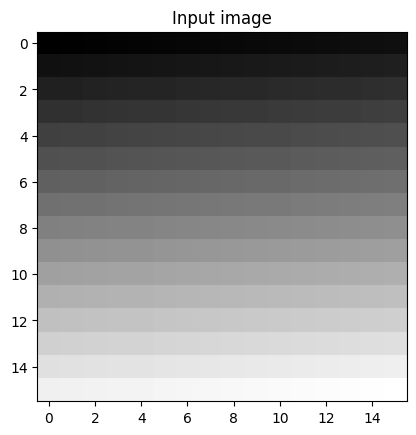

In [13]:
# INPUT
n = 256
shape = (int(math.sqrt(n)), int(math.sqrt(n)))

input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)
plt.imshow(np.reshape(input_vector, shape), cmap='gray')
plt.title('Input image')

input_angles = np.interp(input_vector, (0, 255), (0, np.pi/2))
print(input_vector,"\n", input_angles)

In [14]:
# ENCODER
def frqiEncoder(qc: QuantumCircuit, angles: np.array, measure: bool = False):
    coord_q_num = int(np.ceil(math.log(len(angles), 2)))

    q = QuantumRegister(1,'q')                          # gray value
    Q = QuantumRegister(coord_q_num, 'Q')               # coords
    c = ClassicalRegister(Q.size+q.size, "c")           # measurement

    qc.add_register(q, Q, c)

    qc.id(q)
    qc.h(Q)

    controls_ = []
    for i in Q:
        controls_.append(i)

    for i, theta in enumerate(angles):
        qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(Q[k])
                
        qc.barrier()

        # for coord_or_intns in (0,1):
        qc.mcry(theta= 2*theta, q_controls=controls_, q_target=q[0])

        qc.barrier()
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(Q[k])

    sv = Statevector(qc)
    
    if measure: qc.measure(list(reversed(range(qc.num_qubits))), list(range(c.size)))
    else: qc.barrier()

    return sv

In [21]:
# Setup basic circuit:
circuit = QuantumCircuit()
frqi_StateVec = frqiEncoder(circuit, input_angles, measure=False)

print(f"{frqi_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
# display(circuit.draw())
# circuit_drawer(circuit=circuit, output='latex_source')

Statevector([ 8.64155215e-16-4.12688960e-15j,
              6.25000000e-02-4.90742904e-15j,
              4.43300817e-02-3.22168565e-15j,
              4.40578467e-02-2.24433722e-15j,
              2.40066093e-02-3.58337419e-15j,
              5.77055691e-02-3.95339557e-15j,
              5.78523537e-02-3.59098478e-15j,
              2.36506906e-02+7.10087016e-16j,
              1.22403417e-02-3.87553391e-15j,
              6.12896732e-02-4.50082286e-15j,
              5.21001491e-02-3.44603042e-15j,
              3.45228108e-02-9.64735040e-16j,
              3.48430900e-02-3.23854850e-15j,
              5.18865019e-02-3.11609314e-15j,
              6.13639102e-02-4.18163342e-15j,
              1.18625683e-02+2.22403388e-15j,
              6.15001739e-03-4.21230678e-15j,
              6.21966823e-02-4.83073976e-15j,
              4.84502485e-02-3.50066242e-15j,
              3.94819379e-02-1.61054954e-15j,
              2.95683473e-02-3.74285801e-15j,
              5.50632621e-02-3.725

<IPython.core.display.Latex object>

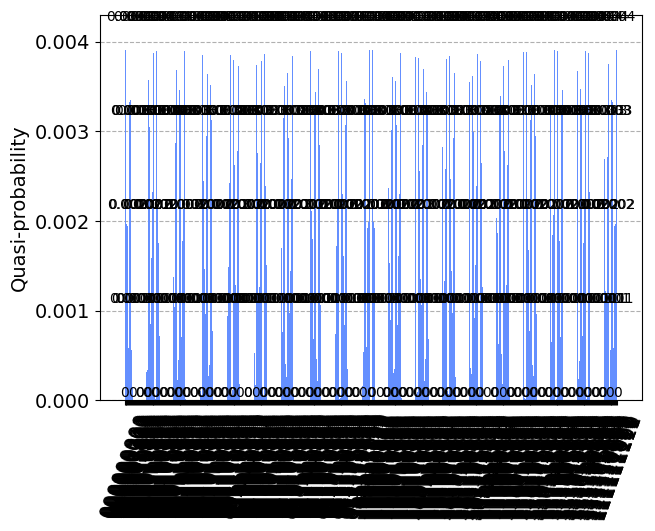

In [17]:
display(frqi_StateVec.draw('latex'))

plot_distribution(frqi_StateVec.probabilities_dict())

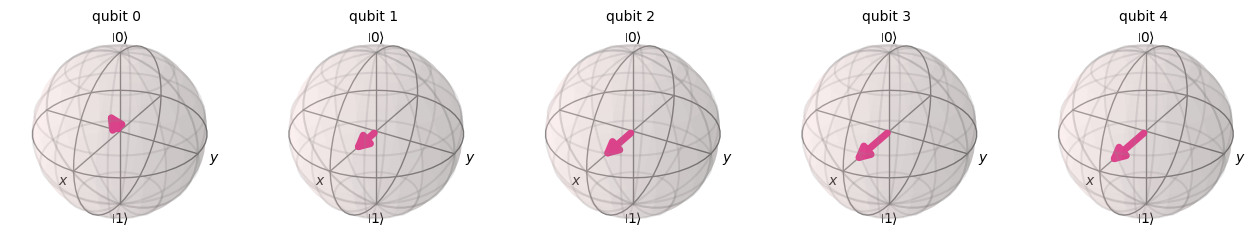

In [16]:
display(plot_bloch_multivector(frqi_StateVec))

In [22]:
# INVERTING THE PIXELS - WIP
circuit.x(circuit.qregs[0])

circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'q'), 0), Qubit(QuantumRegister(8, 'Q'), 0), Qubit(QuantumRegister(8, 'Q'), 1), Qubit(QuantumRegister(8, 'Q'), 2), Qubit(QuantumRegister(8, 'Q'), 3), Qubit(QuantumRegister(8, 'Q'), 4), Qubit(QuantumRegister(8, 'Q'), 5), Qubit(QuantumRegister(8, 'Q'), 6), Qubit(QuantumRegister(8, 'Q'), 7)), clbits=())

<IPython.core.display.Latex object>

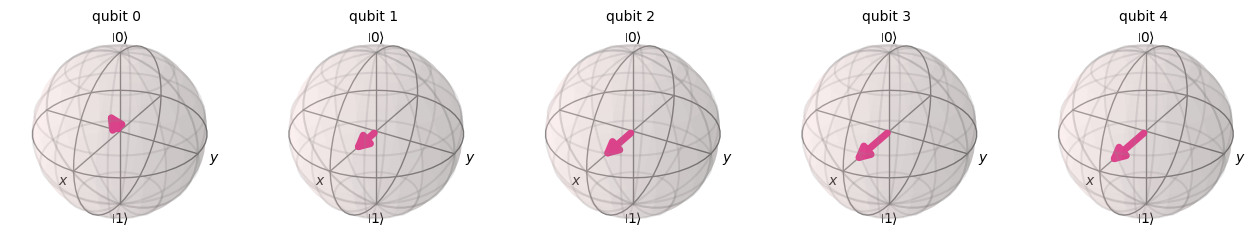

In [17]:
display(Statevector(circuit).draw('latex'))
plot_bloch_multivector(Statevector(circuit))

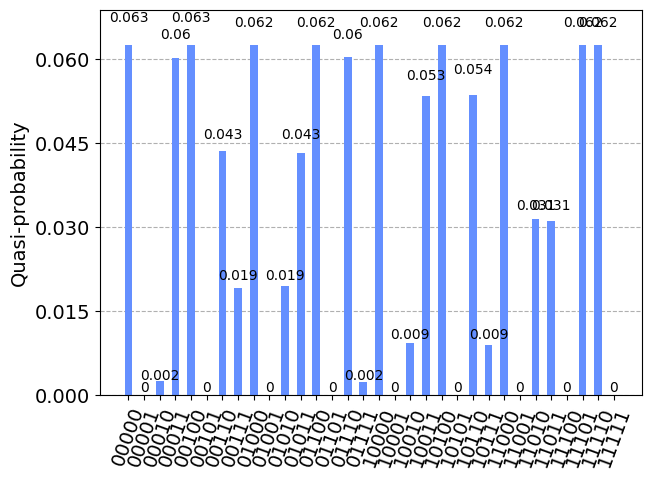

In [18]:
plot_distribution(Statevector(circuit).probabilities_dict())

In [23]:
# measurements
circuit.measure(list(reversed(range(circuit.num_qubits))), list(range(circuit.cregs[0].size)))

print(f"Depth: {circuit.depth()}, Width: {circuit.num_qubits}")
# circuit.draw()

Depth: 2554, Width: 9


In [7]:
aer_sim = Aer.get_backend('aer_simulator')
circuit_t = transpile(circuit, aer_sim, basis_gates=['u', 'cx'])
circuit_t.draw()

░ ┌─────────────┐┌───┐┌─────────────┐┌───┐┌────────────┐»
  q: ───────────────░─┤ U(π/2,0,-π) ├┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0,π/4) ├»
     ┌────────────┐ ░ └─────────────┘└─┬─┘└─────────────┘└─┬─┘└────────────┘»
Q_0: ┤ U(π/2,0,π) ├─░──────────────────┼───────────────────■────────────────»
     ├────────────┤ ░                  │                                    »
Q_1: ┤ U(π/2,0,π) ├─░──────────────────■────────────────────────────────────»
     └────────────┘ ░                                                       »
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───┐┌─────────────┐┌───┐┌───────────────────────┐                    »
«  q: ┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0.96225,-0.17685) ├────────────────────»
«     └─┬─┘└─────────────┘└─┬─┘└───────────────────────┘ ┌────────────┐     »
«Q_0: ──┼───────────────────■──────────────■─────────────┤ U(0,0,π/4) ├──■──»
«       │   ┌────────────┐               ┌─┴─┐          ┌┴────────────┤┌─┴─┐»
«Q_1: ──■───┤ U(0,0,π/4) ├───────────────┤ X ├──────────┤ U(0,0,-π/4) ├┤ X ├»
«           └────────────┘               └───┘          └─────────────┘└───┘»
«c: 3/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐┌─────────────┐┌───┐┌────────────┐┌───┐┌─────────────┐┌───┐»
«  q: ┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├┤ X ├»
«     └─┬─┘└─────────────┘└─┬─┘└────────────┘└─┬─┘└─────────────┘└─┬─┘»
«Q_0: ──┼───────────────────■──────────────────┼───────────────────■──»
«       │                                      │   ┌────────────┐     »
«Q_1: ──■──────────────────────────────────────■───┤ U(0,0,π/4) ├─────»
«                                                  └────────────┘     »
«c: 3/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌────────────────┐                     ░              ░ ┌─────────────┐»
«  q: ┤ U(π/2,0,-3π/4) ├─────────────────────░──────────────░─┤ U(π/3,0,-π) ├»
«     └────────────────┘ ┌────────────┐      ░              ░ └─────────────┘»
«Q_0: ────────■──────────┤ U(0,0,π/4) ├──■───░──────────────░────────────────»
«           ┌─┴─┐       ┌┴────────────┤┌─┴─┐ ░ ┌──────────┐ ░                »
«Q_1: ──────┤ X ├───────┤ U(0,0,-π/4) ├┤ X ├─░─┤ U(π,0,π) ├─░────────────────»
«           └───┘       └─────────────┘└───┘ ░ └──────────┘ ░                »
«c: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«     ┌───┐┌─────────────┐┌───┐┌────────────┐┌───┐┌─────────────┐┌───┐»
«  q: ┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├┤ X ├»
«     └─┬─┘└─────────────┘└─┬─┘└────────────┘└─┬─┘└─────────────┘└─┬─┘»
«Q_0: ──┼───────────────────■──────────────────┼───────────────────■──»
«       │                                      │   ┌────────────┐     »
«Q_1: ──■──────────────────────────────────────■───┤ U(0,0,π/4) ├─────»
«                                                  └────────────┘     »
«c: 3/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌──────────────┐                    ┌───┐┌─────────────┐┌───┐»
«  q: ┤ U(π/6,0,π/4) ├────────────────────┤ X ├┤ U(0,0,-π/4) ├┤ X ├»
«     └──────────────┘ ┌────────────┐     └─┬─┘└─────────────┘└─┬─┘»
«Q_0: ───────■─────────┤ U(0,0,π/4) ├──■────┼───────────────────■──»
«          ┌─┴─┐      ┌┴────────────┤┌─┴─┐  │                      »
«Q_1: ─────┤ X ├──────┤ U(0,0,-π/4) ├┤ X ├──■──────────────────────»
«          └───┘      └─────────────┘└───┘                         »
«c: 3/═════════════════════════════════════════════════════════════»
«                                                        

In [31]:
# SIMULATE
shots = 5000
aer_sim = AerSimulator()
t_qc_image = transpile(circuit, aer_sim)
# qobj = aer_sim(t_qc_image, shots=shots)
job = aer_sim.run(t_qc_image, shots=shots)
result = job.result()
counts = result.get_counts()

print(counts)
# plot_histogram(counts)

{'111001010': 26, '111111011': 29, '100101111': 2, '001101110': 18, '010000000': 6, '101110110': 8, '001010111': 18, '010111011': 6, '110101101': 12, '011000001': 1, '111101000': 17, '010110011': 2, '001011111': 10, '111111000': 15, '110110000': 16, '111011011': 23, '010111110': 4, '101110001': 10, '001010000': 13, '111000100': 11, '100111101': 3, '000011110': 21, '101010010': 6, '001100000': 11, '100100011': 2, '011000100': 2, '100001011': 1, '001001110': 14, '001110000': 10, '000111101': 22, '000100011': 13, '111010111': 21, '110111110': 16, '110100101': 12, '110100110': 18, '000101101': 16, '000110011': 15, '001000010': 22, '101111000': 17, '001011001': 12, '101011011': 3, '100110100': 3, '000010101': 17, '000101011': 11, '000110101': 25, '000000010': 24, '001001001': 15, '000111000': 16, '101110111': 7, '010111100': 4, '001010110': 18, '110011001': 19, '110001000': 7, '010000011': 13, '101111110': 13, '001011101': 20, '010110001': 4, '101101110': 11, '110000111': 12, '110100001': 1

In [42]:
print(f"Depth: {t_qc_image.depth()}, Width: {t_qc_image.num_qubits}")

t_qc_image.draw()

Depth: 23, Width: 3


┌───┐ ░ ┌───────┐┌───┐┌───────┐┌───┐ ░       ░ ┌─────────┐┌───┐»
  q: ┤ I ├─░─┤ Ry(0) ├┤ X ├┤ Ry(0) ├┤ X ├─░───────░─┤ Ry(π/6) ├┤ X ├»
     ├───┤ ░ └───────┘└─┬─┘└───────┘└─┬─┘ ░       ░ └─────────┘└─┬─┘»
Q_0: ┤ H ├─░────────────■─────────────■───░───────░──────────────■──»
     ├───┤ ░            │             │   ░ ┌───┐ ░              │  »
Q_1: ┤ H ├─░────────────■─────────────■───░─┤ X ├─░──────────────■──»
     └───┘ ░                              ░ └───┘ ░                 »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«     ┌──────────┐┌───┐ ░       ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ »
«  q: ┤ Ry(-π/6) ├┤ X ├─░───────░─┤ Ry(π/3) ├┤ X ├┤ Ry(-π/3) ├┤ X ├─░───────░─»
«     └──────────┘└─┬─┘ ░ ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░       ░ »
«Q_0: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░───────░─»
«                   │   ░ ├───┤ ░              │                │   ░ ┌───┐ ░ »
«Q_1: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├─░─»
«                       ░ └───┘ ░                                   ░ └───┘ ░ »
«c: 3/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ ┌───┐ ░       ┌─┐
«  q: ┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├─░───────░─┤ X ├─░───────┤M├
«     └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐ ░ └───┘ ░    ┌─┐└╥┘
«Q_0: ─────────────■────────────────■───░─┤ X ├─░───────░────┤M├─╫─
«                  │                │   ░ ├───┤ ░       ░ ┌─┐└╥┘ ║ 
«Q_1: ─────────────■────────────────■───░─┤ X ├─░───────░─┤M├─╫──╫─
«                                       ░ └───┘ ░       ░ └╥┘ ║  ║ 
«c: 3/═════════════════════════════════════════════════════╩══╩══╩═
«                                                          0  1  2

For decoding, we need the gray value for every pixel. Following formula is used to calculate the values:

$$
\upsilon = \arccos \left(\sqrt{\frac{P(j||0\rangle)}{P(j||0\rangle) + P(j||1\rangle)}}\right)
$$
where,  
$P(j||0\rangle)$ is the conditional probability of observing a state $j$ given that the gray value of the qubit is in state $|0\rangle$,  
Similarly, $P(j||1\rangle)$ is to probability of observing a state $j$ given that the gray value of the qubit is in state $|1\rangle$.  

This value is in radians and must be interpolated back from (0, $\pi/2$) to (0, 255).

In our case, the first qubit is associated with the gray value and the other qubits store the coordinates of that pixel.
1. For each pixel, we will iterate over every output state and check the coordinates of the state. If these coordinates match with the selected pixel, we will store the value.
2. We will iterate over the color values for that pixel, and calculate the total count, when that pixel had value '0'.
3. Use the above formula to get the exact value.
4. Interpolate back in range (0, 255).

In [32]:
# RECONSTRUCT
reconstruct = []

for i in range(len(input_vector)):
    # print(f"\nFor pixel at coords {i}:")
    color_list = []                         # stores the values 

    # step 1
    for key, count in counts.items():
        int_coord = int(key[1:], 2)         # all qubits but 1st will store coordinates
        
        # if coordinates match with pixel in focus, store the gray value and count
        if int_coord == i:
            color_list.append((key[0], count))        
    # print(f"\tGray value of matching states and their counts: {color_list}")

    # step 2
    zero_count = 0                          # total count for gray value = 0
    for gvalue, count in color_list:
        if not int(gvalue):                 # if gvalue == 0, get total for P(j||0>)
            zero_count = zero_count + count
    # print(f"\tTotal count where gray value is 0 = P(j||0>) = {zero_count}")

    # step 3
    try:
        gvalue = np.arccos((zero_count/sum(n for _, n in color_list))**(1/2))
        reconstruct.append(gvalue)
        # print(f"\tarccos(sqrt(zero_count / total_count)): {gvalue}")
    except ZeroDivisionError:
        print("\tZeroDivisionError")

# step 4 (readout is reversed as we used 1st qubit for gray value instead of the last qubit)
reconstruct = list(reversed(np.interp(reconstruct, (0, np.pi/2), (0, 255)).astype(int)))
print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {reconstruct}")


Original values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

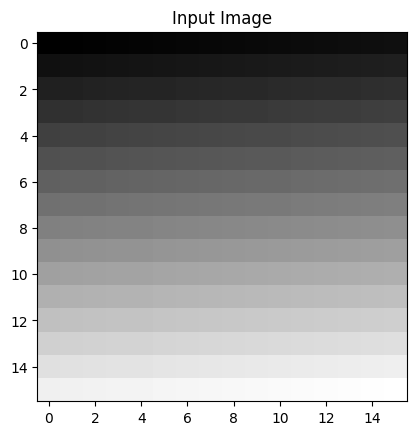

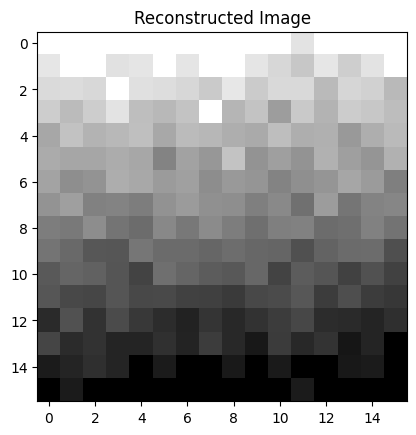

In [30]:
def plot_to_compare(input_vector, reconstruct):
    plt.imshow(np.reshape(input_vector, shape), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(reconstruct, shape), cmap = 'gray')
    plt.title('Reconstructed Image')
    plt.show()

plot_to_compare(input_vector, reconstruct)

Detailed discussion and implementation, based on Qiskit textbook can be found [here](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/image-processing-frqi-neqr.ipynb) and [here](https://physlab.org/wp-content/uploads/2023/05/QImage_Rep_22120005_Fin.pdf).